<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/NLP/DZ2_text_classification_berta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

Для закрепления материала модуля предлагаем вам поучаствовать в учебном [Kaggle-соревновании](https://www.kaggle.com/competitions/unit-3-nlp-txt-classification/data).

Вам необходимо решить задачу классификации текстов, используя рекуррентные сети.
______

При выполнении проекта разрешается пользоваться любыми средствами для векторных представлений текстов, кроме трансформеров, и любыми вариантами рекуррентных сетей. Для достижения наилучшего результата уделите внимание подбору гиперапарметров как в плане архитектуры, так и в плане обучения модели.
______

Критерии самооценивания проекта:

- общее качество кода и следование PEP-8;
- использование рекуррентных сетей;
- итоговое значение метрики качества.

# Подключение к Kaggle

In [ ]:
api_token = {"username":"...","key":"..."}

import json

with open('/content/kaggle.json', 'w') as file:
  json.dump(api_token, file)

In [ ]:
# Загрузка датасета с Кеггла
!pip install kaggle -q
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.12 -q
!kaggle --version

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Kaggle API 1.5.12


# Загрузка данных соревнования

In [ ]:
!kaggle competitions download -c unit-3-nlp-txt-classification
!unzip '/content/unit-3-nlp-txt-classification.zip' -d'/content/data/'

  0% 0.00/4.08M [00:00<?, ?B/s]
100% 4.08M/4.08M [00:00<00:00, 112MB/s]
Archive:  /content/unit-3-nlp-txt-classification.zip
  inflating: /content/data/sample_submission.csv  
  inflating: /content/data/test.csv  
  inflating: /content/data/train.csv  


In [ ]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

os.listdir() # корневая папка

['.config',
 'data',
 'unit-3-nlp-txt-classification.zip',
 'kaggle.json',
 'sample_data']

## Читаем все в датафреймы.

In [ ]:
INPUT_PATH = '/content/data'  # папка с данными
# данные для обучения
main_ds = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'), index_col=0)
# тестовые данные
test_ds = pd.read_csv(os.path.join(INPUT_PATH, 'test.csv'), index_col=0)
# пример для загрузки ответов
sample_submission = pd.read_csv(os.path.join(INPUT_PATH, 'sample_submission.csv'))
# размер данных
main_ds.shape, test_ds.shape, sample_submission.shape

((41159, 2), (3798, 1), (3798, 2))

In [ ]:
# train dataset
main_ds.head()

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
main_ds.sample(1).Text.tolist()[0]

'Food Depot located in Baltimore Maryland is jacking up the prices on food tissue and toilet paper In most states price gouging during a time of emergency is considered a violation of unfair or deceptive trade practices law'

In [ ]:
# train dataset Sentiment.value_counts()
main_ds.Sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7711
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [ ]:
# test dataset
main_ds.head()

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
# sample_submission
print(sample_submission.Sentiment.value_counts())
print()
sample_submission.head()


Neutral    3798
Name: Sentiment, dtype: int64



,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Neutral
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Neutral
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Neutral
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Neutral
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral


## Импорты и константы

In [ ]:
import time
import re
from tqdm import tqdm



In [ ]:
NUM_CLASSES = len(main_ds.Sentiment.value_counts().index)
print(f'NUM_CLASSES = {NUM_CLASSES}')


NUM_CLASSES = 5


## Чистка и предобработка

In [ ]:
# пропуски
main_ds.isna().sum()

Text         1
Sentiment    4
dtype: int64

Есть совсем немного (от 4 до 6) NaNов в 41159 строках. Проще от них избавиться.

In [ ]:
# удаляем
main_ds = main_ds.dropna()
main_ds.isna().sum()

Text         0
Sentiment    0
dtype: int64

## Есть ли баланс в данных?

Extremely Negative     5481
Extremely Positive     6624
Negative               9917
Neutral                7711
Positive              11422
Name: Sentiment, dtype: int64


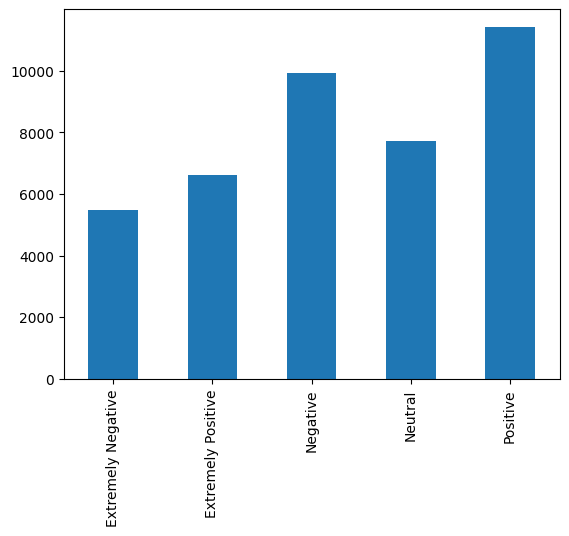

In [ ]:
# давайте посмотрим распределение оценок
import matplotlib.pyplot as plt
%matplotlib inline
# value_counts () - a command that allows you to calculate the number of unique values
vc = main_ds.Sentiment.value_counts()
vc = vc.sort_index()
print(vc)
vc.plot(kind='bar');

Самый частый класс больше самого редкого в два раза. Пока как есть пробуем.

На следующем этаме можно добавить аугментацию

Посмотрим на длину текстов.

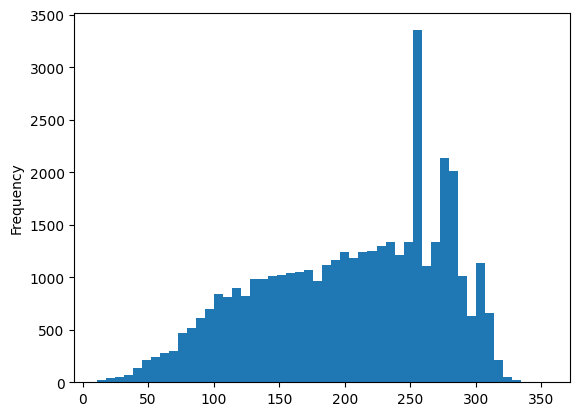

In [ ]:
lens = main_ds.Text.apply(lambda s: len(s))
lens.plot.hist(bins=50);

In [ ]:
lens.quantile(0.95), max(lens)

(300.0, 355)

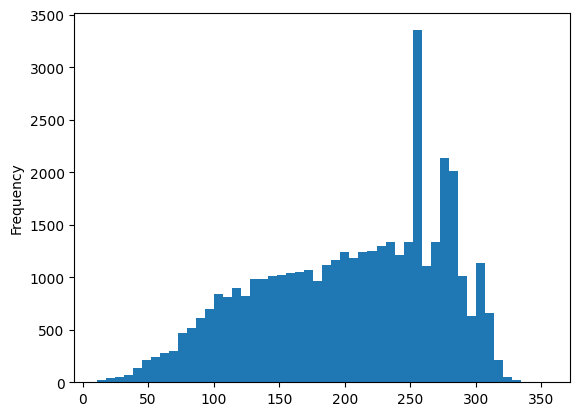

In [ ]:
lens = main_ds.Text.apply(lambda s: len(s))
lens.plot.hist(bins=50);

In [ ]:
lens.quantile(0.95), max(lens)

(300.0, 355)

# Sentences cleaning

Подберем то, что мы очищаем в данных

## abbreviaturs clearning

In [ ]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
abbreviations = {
    "Â": "'",
    "$" : " dollar ",
    "€" : " euro ",
    "Â" : "",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired",
}

In [ ]:
def convert_abbrev(text):
    new_text = ''
    for word in text.split():
      if word.lower() in abbreviations.keys():
        new_text += ' ' + word[0] + abbreviations[word.lower()][1:]
      else:
        new_text += ' ' + word
    return ' '.join(new_text.split())

In [ ]:
#sentence = main_ds.sample().Text.values[0]
sentence = "So ygtr now weÂre NOT supposed to go to the grocery store??  Really? Did I miss this before? #TrumpPressBriefing #COVID2019"
print(sentence)
print()
sentence = convert_abbrev(sentence)
print(sentence)

So ygtr now weÂre NOT supposed to go to the grocery store??  Really? Did I miss this before? #TrumpPressBriefing #COVID2019

So you got that right now weÂre NOT supposed to go to the grocery store?? Really? Did I miss this before? #TrumpPressBriefing #COVID2019


## Phrases with apostrophes

Словосочетания с апострофами в английском лушче раскрыть.

In [ ]:
contraction_dict = {"ain't": "is not",
                    "aren't": "are not",
                    "can't": "can not",
                    "'cause": "because",
                    "could've": "could have",
                    "couldn't": "could not",
                    "didn't": "did not",
                    "doesn't": "does not",
                    "don't": "do not",
                    "hadn't": "had not",
                    "hasn't": "has not",
                    "haven't": "have not",
                    "he'd": "he would",
                    "he'll": "he will",
                    "he's": "he is",
                    "how'd": "how did",
                    "how'd'y": "how do you",
                    "how'll": "how will",
                    "how's": "how is",
                    "I'd": "I would",
                    "I'd've": "I would have",
                    "I'll": "I will",
                    "I'll've": "I will have",
                    "I'm": "I am",
                    "I've": "I have",
                    "i'd": "i would",
                    "i'd've": "i would have",
                    "i'll": "i will",
                    "i'll've": "i will have",
                    "i'm": "i am",
                    "i've": "i have",
                    "isn't": "is not",
                    "it'd": "it would",
                    "it'd've": "it would have",
                    "it'll": "it will",
                    "it'll've": "it will have",
                    "it's": "it is",
                    "let's": "let us",
                    "ma'am": "madam",
                    "mayn't": "may not",
                    "might've": "might have",
                    "mightn't": "might not",
                    "mightn't've": "might not have",
                    "must've": "must have",
                    "mustn't": "must not",
                    "mustn't've": "must not have",
                    "needn't": "need not",
                    "needn't've": "need not have",
                    "o'clock": "of the clock",
                    "oughtn't": "ought not",
                    "oughtn't've": "ought not have",
                    "shan't": "shall not",
                    "sha'n't": "shall not",
                    "shan't've": "shall not have",
                    "she'd": "she would",
                    "she'd've": "she would have",
                    "she'll": "she will",
                    "she'll've": "she will have",
                    "she's": "she is",
                    "should've": "should have",
                    "shouldn't": "should not",
                    "shouldn't've": "should not have",
                    "so've": "so have",
                    "so's": "so as",
                    "this's": "this is",
                    "that'd": "that would",
                    "that'd've": "that would have",
                    "that's": "that is",
                    "there'd": "there would",
                    "there'd've": "there would have",
                    "there's": "there is",
                    "here's": "here is",
                    "they'd": "they would",
                    "they'd've": "they would have",
                    "they'll": "they will",
                    "they'll've": "they will have",
                    "they're": "they are",
                    "they've": "they have",
                    "to've": "to have",
                    "wasn't": "was not",
                    "we'd": "we would",
                    "we'd've": "we would have",
                    "we'll": "we will",
                    "we'll've": "we will have",
                    "we're": "we are",
                    "we've": "we have",
                    "weren't": "were not",
                    "what'll": "what will",
                    "what'll've": "what will have",
                    "what're": "what are",
                    "what's": "what is",
                    "what've": "what have",
                    "when's": "when is",
                    "when've": "when have",
                    "where'd": "where did",
                    "where's": "where is",
                    "where've": "where have",
                    "who'll": "who will",
                    "who'll've": "who will have",
                    "who's": "who is",
                    "who've": "who have",
                    "why's": "why is",
                    "why've": "why have",
                    "will've": "will have",
                    "won't": "will not",
                    "won't've": "will not have",
                    "would've": "would have",
                    "wouldn't": "would not",
                    "wouldn't've": "would not have",
                    "y'all": "you all",
                    "y'all'd": "you all would",
                    "y'all'd've": "you all would have",
                    "y'all're": "you all are",
                    "y'all've": "you all have",
                    "you'd": "you would",
                    "you'd've": "you would have",
                    "you'll": "you will",
                    "you'll've": "you will have",
                    "you're": "you are",
                    "you've": "you have"}

In [ ]:
def convert_contractions(text):
    new_text = ''
    for word in text.split():
      if word.lower() in contraction_dict.keys():
        new_text += ' ' + word[0] + contraction_dict[word.lower()][1:]
      else:
        new_text += ' ' + word
    return ' '.join(new_text.split())

In [ ]:
sentence = "We're running as much product as we can, harvesting as many chickens as we can, (and) we are working Saturdays if we have the supply" #
print(sentence)
print()
print(convert_contractions(sentence))

We're running as much product as we can, harvesting as many chickens as we can, (and) we are working Saturdays if we have the supply

We are running as much product as we can, harvesting as many chickens as we can, (and) we are working Saturdays if we have the supply


##Convert Emojis

In [ ]:
!pip install demoji -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.1 MB/s eta 0:00:00


In [ ]:
import demoji

demoji.download_codes()

In [ ]:
#converting Emojis
def convert_emoji(text):
  new_text = ''
  for word in text.split():
    emj = demoji.findall_list(word)
    if len(emj):
      new_text+=' ' + ''.join((c +' ') for c in emj)
    else: new_text+=' ' +word
  return new_text

In [ ]:
sentence = main_ds.sample().Text.values[0] + "\U0001F600-\U0001F64F"
print(sentence)
print()
print(convert_emoji(sentence))

@Nigella_Lawson Feeling very angry after going to the supermarket and also seeing images of our most vulnerable. Wrote this: ÂThe old man wasn't sure what to do.Â https://t.co/Kz3M7tbsFn #COVID19 #coronavirus https://t.co/AAlPv2heeL😀-🙏

 @Nigella_Lawson Feeling very angry after going to the supermarket and also seeing images of our most vulnerable. Wrote this: ÂThe old man wasn't sure what to do.Â https://t.co/Kz3M7tbsFn #COVID19 #coronavirus grinning face folded hands 


## Remove special characters

In [ ]:
import string
from bs4 import BeautifulSoup
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

#Removing URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

#Removing the noisy text
def denoise_text(text):
    text = remove_URL(text)
    text = remove_between_square_brackets(text)
    text = remove_punct(text)
    return text

In [ ]:
sentence = main_ds.sample().Text.values[0]
print(sentence)
print()
print(denoise_text(sentence))

No matter how bad it gets, no one wants Âdude wipesÂ. People using napkins and sandpaper. #coronavirus #COVID2019 #dudewipes #ToiletPaperPanic #toiletpaper https://t.co/fS4Sywiue8

No matter how bad it gets no one wants Âdude wipesÂ People using napkins and sandpaper coronavirus COVID2019 dudewipes ToiletPaperPanic toiletpaper 


In [ ]:
def remove_special_characters(text, remove_digits=True):
    text = re.sub('http://\S+|https://\S+|www.\S+|\n|#|\r', '', text)
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text.strip()

In [ ]:
print(sentence)
print()
remove_special_characters(sentence)

No matter how bad it gets, no one wants Âdude wipesÂ. People using napkins and sandpaper. #coronavirus #COVID2019 #dudewipes #ToiletPaperPanic #toiletpaper https://t.co/fS4Sywiue8



'No matter how bad it gets no one wants dude wipes People using napkins and sandpaper coronavirus COVID dudewipes ToiletPaperPanic toiletpaper'

In [ ]:
def convert2several_words(text):
  return "".join((" " + w if (w.isupper() and i) else w) for i, w in enumerate(text))#.strip().split() #' '.join(w for w in re.findall('[A-Z][^A-Z]*', text))

In [ ]:
def convert2several_words(text):
  new_text = ''
  for word in text.split():
    if not word.isupper():
      word = "".join((" " + w if (w.isupper() and i) else w) for i, w in enumerate(word))
      new_text+= " " + word
    else:
      new_text+=' '+word
  return ' '.join(new_text.split())

In [ ]:
sentence = 'With apologies this is that Talkwalker post consumer trends for content in coronavirus times DigitalMarketing'
convert2several_words(sentence)

'With apologies this is that Talkwalker post consumer trends for content in coronavirus times Digital Marketing'

## Mix clearing

In [ ]:
#Collect all functions
def clean_text(text):
    text = remove_URL(text)
    text = convert_emoji(text)
    text = convert_abbrev(text)
    text = convert_contractions(text)
    text = convert2several_words(text)
    text = denoise_text(text)
    ext = remove_special_characters(text)
    #text = remove_stopwords(text)
    return ' '.join(text.split())

In [ ]:
sentence = main_ds.sample().Text.values[0]
print(sentence)
print()
print(clean_text(sentence))

Surge in Online Shopping Drives Major Increase in Themed Fraud Attempts Full article from

Surge in Online Shopping Drives Major Increase in Themed Fraud Attempts Full article from


In [ ]:
%timeit
main_ds['Text_clean'] = main_ds['Text'].apply(clean_text)
test_ds['Text_clean'] = test_ds['Text'].apply(clean_text)
main_ds.head()

,Text,Sentiment,Text_clean
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Me Nyrbie Phil Gahan Chrisitv and and
1,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia Woolworths to give elder...
3,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Me ready to go at supermarket during the COVID...


In [ ]:
main_ds.sample(10)

,Text,Sentiment,Text_clean
4155,Just went to the grocery store....let me tell ...,Neutral,Just went to the grocery storelet me tell you ...
12597,President Uhuru Kenyatta warned traders I e sh...,Negative,President Uhuru Kenyatta warned traders I e sh...
17392,Competition amp consumer law developments affe...,Neutral,Competition amp consumer law developments affe...
9630,Instead of reassuring ourselves of our luxurie...,Extremely Positive,Instead of reassuring ourselves of our luxurie...
23058,Covid-19 coronavirus: Rotorua shoppers wear be...,Neutral,Covid19 coronavirus Rotorua shoppers wear beek...
3933,staying home and shopping online?\r\r\nFor a l...,Negative,staying home and shopping online For a limited...
7243,Sadly people are profiting from the #coronavir...,Negative,Sadly people are profiting from the coronaviru...
18306,"A #coronavirus question, \r\r\nWhat about chec...",Neutral,A coronavirus question What about checking you...
2525,Covid-19 induced panic buying from the U.S to ...,Negative,Covid19 induced panic buying from the US to Fr...
5831,My thanks to every person working in harms way...,Negative,My thanks to every person working in harms way...


# Look again

In [ ]:
def length(text):
    '''a function which returns the length of text'''
    return len(text)

Сьлвари для первода из имени класса в номер класса и обратно

In [ ]:
dict_lbl_to_sent = {k: v for k, v in enumerate(main_ds['Sentiment'].unique())}
dict_sent_to_lbl = {v: k for k, v in dict_lbl_to_sent.items()}
print(f'Encoded sentiment values: {dict_sent_to_lbl}')

Encoded sentiment values: {'Neutral': 0, 'Positive': 1, 'Extremely Negative': 2, 'Negative': 3, 'Extremely Positive': 4}


Добавим номера классов

In [ ]:
main_ds['Label'] = main_ds['Sentiment'].apply(lambda x: dict_sent_to_lbl[x])

Добавим длину текстов

In [ ]:
main_ds['length_text_clean'] = main_ds['Text_clean'].apply(length)
test_ds['length_text_clean'] = test_ds['Text_clean'].apply(length)

## Number of characters in text

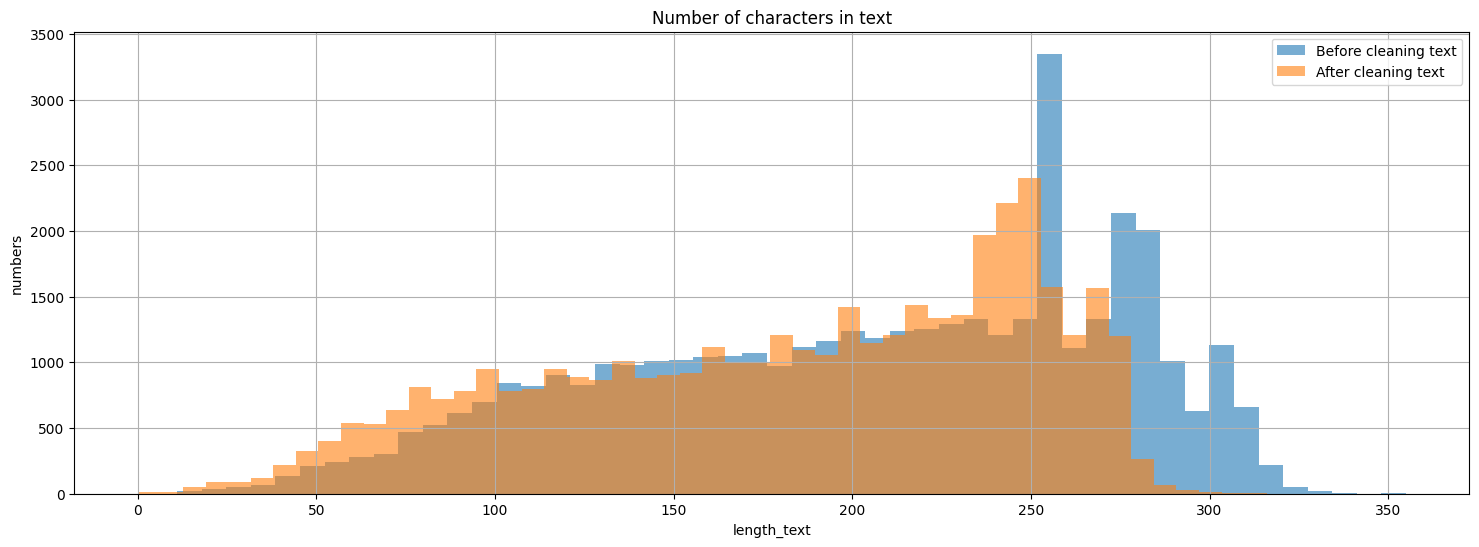

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 50
plt.hist(main_ds.Text.apply(length), alpha = 0.6, bins=bins, label='Before cleaning text')
plt.hist(main_ds['length_text_clean'], alpha = 0.6, bins=bins, label='After cleaning text')
plt.xlabel('length_text')
plt.ylabel('numbers')
plt.title('Number of characters in text')
plt.legend(loc='upper right')
plt.grid()
plt.show()

## Number of words in a text

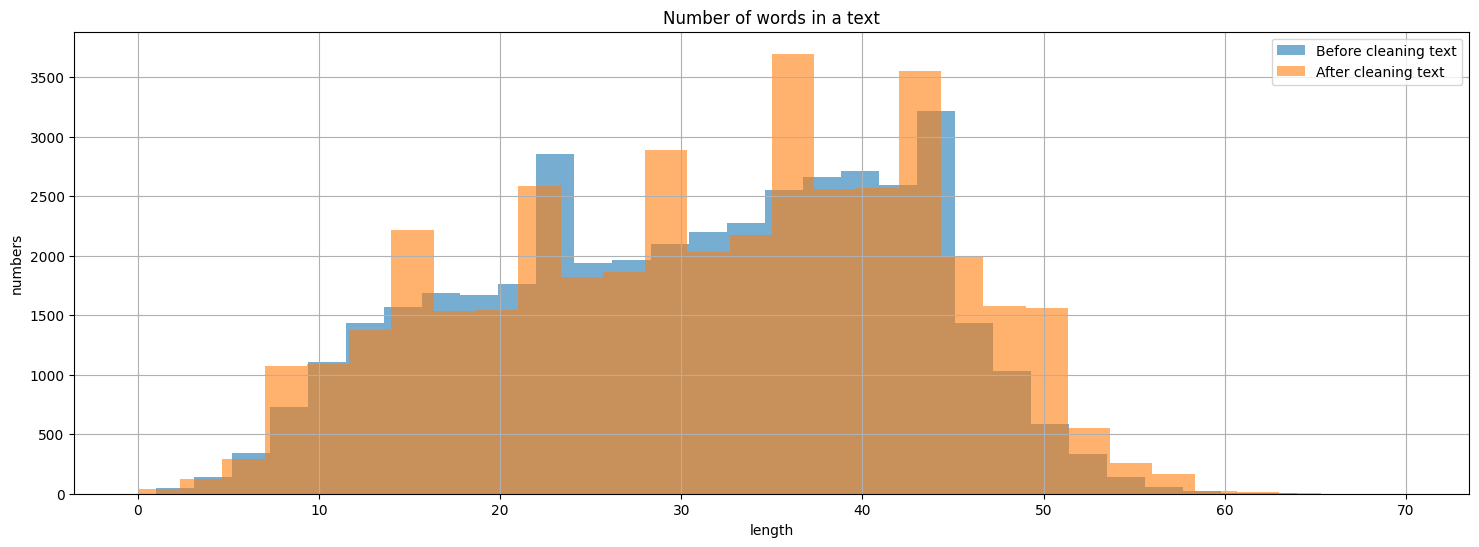

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 30
text_len=main_ds['Text'].str.split().map(lambda x: len(x))
text_len_clean=main_ds['Text_clean'].str.split().map(lambda x: len(x))
plt.hist(text_len, alpha = 0.6, bins=bins, label='Before cleaning text')
plt.hist(text_len_clean, alpha = 0.6, bins=bins, label='After cleaning text')
plt.xlabel('length')
plt.ylabel('numbers')
plt.title('Number of words in a text')
plt.legend(loc='upper right')
plt.grid()
plt.show()

## Removing blank lines


In [ ]:
main_ds[main_ds.length_text_clean == 0]

,Text,Sentiment,Text_clean,Label,length_text_clean
583,#????_???_?????? ???? ???????..? ?? ?????? ?? ...,Neutral,,0,0
5214,???? ???????? ??????????? - ???????? ?????????...,Neutral,,0,0
13843,? ???? ????? ???? ??? ?????? ??? ???\r\r\n\r\r...,Neutral,,0,0
14840,???? ??????? ??????? ????? ??? ?????? ??????? ...,Neutral,,0,0
16920,???? ??????? ??????? ???? ????? ???? ???? ????...,Neutral,,0,0
16924,????? ?\r\r\n\r\r\n???? ??? ???? ??? ?????????...,Neutral,,0,0
18437,????? ?? ??????? ?? ??????? ???? ???? ????????...,Neutral,,0,0
29888,???? ????? \r\r\n????? ??? ? ?? ?? ??\r\r\n\r\...,Neutral,,0,0
32455,?? ?? ??? ??? ??? ????! https://t.co/2VAcVOugv1,Neutral,,0,0
36781,??? ???? ????? ?? ?????? ???? ????? ? ???? ???...,Neutral,,0,0


In [ ]:
main_ds = main_ds.drop(main_ds[main_ds.length_text_clean == 0].index)

В тестовом стоит также почистить перед предиктом, а этим поставить - `Neutral`

In [ ]:
main_ds[main_ds.length_text_clean == 4]

,Text,Sentiment,Text_clean,Label,length_text_clean


Extremely Negative     5481
Extremely Positive     6624
Negative               9917
Neutral                7701
Positive              11422
Name: Sentiment, dtype: int64


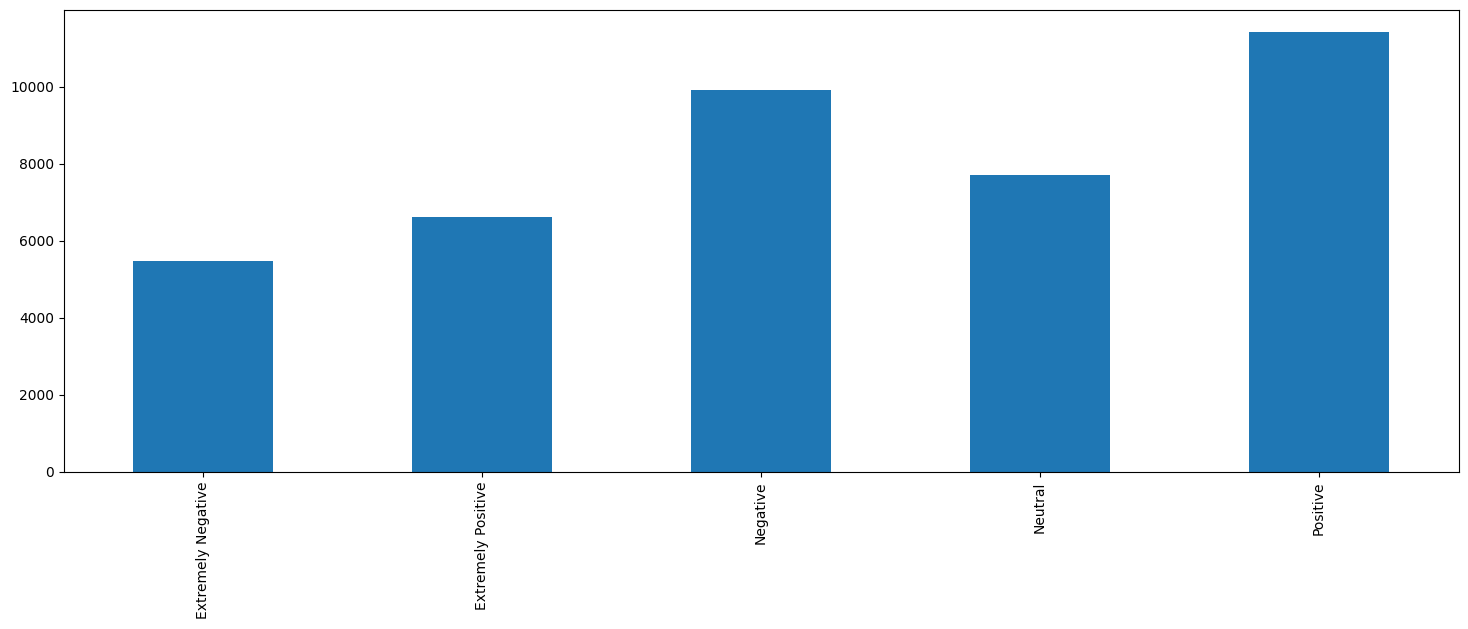

In [ ]:
# value_counts () - a command that allows you to calculate the number of unique values
vc = main_ds.Sentiment.value_counts()
vc = vc.sort_index()
print(vc)
vc.plot(kind='bar');

In [ ]:
main_ds

,Text,Sentiment,Text_clean,Label,length_text_clean
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Me Nyrbie Phil Gahan Chrisitv and and,0,37
1,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...,1,237
2,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia Woolworths to give elder...,1,104
3,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...,1,259
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Me ready to go at supermarket during the COVID...,2,265
...,...,...,...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral,Airline pilots offering to stock supermarket s...,0,75
41153,Response to complaint not provided citing COVI...,Extremely Negative,Response to complaint not provided citing COVI...,2,133
41154,You know itÂs getting tough when @KameronWild...,Positive,You know it Âs getting tough when Kameron Wil...,1,130
41155,Is it wrong that the smell of hand sanitizer i...,Neutral,Is it wrong that the smell of hand sanitizer i...,0,102


# With augmentation datasets

## DataLoader, Dataset

In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
new_df = main_ds[['Text_clean', 'Label']]

### tokenizer, nlpaug

In [ ]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.9 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
!pip install nlpaug -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 4.6 MB/s eta 0:00:00


In [ ]:
import nlpaug
import nlpaug.augmenter.word as naw

In [ ]:
AUG = naw.SynonymAug(aug_src='wordnet', aug_min=5, aug_max=15)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
id = 110
new_df.Text_clean[id]

'A supermarket in La Habra is trying to help local seniors during the COVID19 pandemic by opening its doors a halfhour early each day exclusively for shoppers 65 and older'

In [ ]:
AUG.augment(new_df.Text_clean[id])[0]

'A supermarket in La Habra is essay to aid local seniors during the COVID19 pandemic by opening its doorway a halfhour other each sidereal day exclusively for shoppers 65 and older'

In [ ]:
class SentimenAugtData(Dataset):
    """
    add augmentation
    """
    def __init__(self, dataframe, tokenizer, max_len, aug_min = 0, aug_max = 0):
        self.tokenizer = tokenizer
        self.augment = aug_max
        if aug_max:
            self.AUG = naw.SynonymAug(aug_src='wordnet',
                                      aug_min=aug_min,
                                      aug_max=aug_max)

        self.text = dataframe.Text_clean
        self.targets = dataframe.Label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.AUG.augment(self.text[index])[0] if self.augment else self.text[index]
        text = str(text)
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        #token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            #'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }




In [ ]:
def get_randpart(data, params, part = 0.5, aug = 0):
    """
    take rand part from data with use or not augmentation
    with control classes
    """
    if part<1:
      data, _ = train_test_split(data,
                                stratify= data.Label,
                                test_size=part
                                )

    data = data.reset_index(drop=True)
    if aug:
        aug_min = np.random.randint(2, aug + 2)
        aug_max = np.random.randint(aug + 2, aug + 10)
    else:
      aug_min, aug_max = aug, aug

    data_set =  SentimenAugtData(data, tokenizer, MAX_LEN, aug_min, aug_max)
    data_loader = DataLoader(data_set, **params)
    return data_loader

### Check Max_Len

Долго, уже вычисленно , закомитил

In [ ]:
# Concatenate train data and test data
#all_texts = np.concatenate([main_ds.Text_clean.values, test_ds.Text_clean.values])

# Encode our concatenated data
#encoded_texts = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_texts]

# Find the maximum length
#max_len = max([len(sent) for sent in encoded_texts])
#print('Max length: ', max_len)

Max length:  123


###  train_test_split

In [ ]:
from sklearn.model_selection import train_test_split
SEED = 200
train_size = 0.8
MAX_LEN = 123


train_data, valid_data = train_test_split(new_df,
                                          stratify= new_df.Label,
                                          test_size=0.2,
                                          random_state=SEED)

In [ ]:
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 16

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = get_randpart(data = train_data, params = train_params, aug = 5)
valid_loader =  get_randpart(data = valid_data, params = valid_params, aug = 5, part = 1)

In [ ]:
dataiter = iter(training_loader)
sample = next(dataiter)

In [ ]:
print('Sample ids input size', sample['ids'].size())
print('Sample mask input: \n', sample['mask'].size())
print('Sample targets input: \n', sample['targets'].size())
#print('Sample token_type_ids input: \n', sample['token_type_ids'].size())

print('\nSample ids input size', sample['ids'])
print('Sample label: \n', sample['targets'])

Sample ids input size torch.Size([32, 123])
Sample mask input: 
 torch.Size([32, 123])
Sample targets input: 
 torch.Size([32])

Sample ids input size tensor([[  101,  4429,  2050,  ...,     0,     0,     0],
        [  101, 13025,  3573,  ...,     0,     0,     0],
        [  101,  5862,  2118,  ...,     0,     0,     0],
        ...,
        [  101,  1045,  2228,  ...,     0,     0,     0],
        [  101,  1041, 21360,  ...,     0,     0,     0],
        [  101,  9095,  2005,  ...,     0,     0,     0]])
Sample label: 
 tensor([1., 1., 4., 3., 2., 3., 0., 4., 3., 4., 1., 1., 4., 3., 4., 1., 4., 1.,
        3., 3., 0., 1., 3., 0., 2., 2., 2., 0., 1., 3., 3., 3.])


# Create BertClassifier

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the `[CLS]` token is used as the features of the sequence to feed a classifier.

The `transformers` library has the [`BertForSequenceClassification`](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification) class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the `[CLS]` token and a single-hidden-layer feed-forward neural network as our classifier.

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
%%time
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, num_classes, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')


        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in_1, D_in_2, H_1, H_2, D_out = 1536, 768, 50, 100, num_classes

        # Instantiate an one-layer feed-forward classifier
        self.pre_classifier_1 = nn.Sequential(
            nn.Linear(D_in_1, H_1),
            nn.ReLU(),
            nn.Dropout(0.5))

        self.pre_classifier_2 = nn.Sequential(
            nn.Linear(D_in_2, H_1),
            nn.ReLU(),
            nn.Dropout(0.5))

        self.classifier  =  nn.Linear(H_2, D_out)


        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        hidden_state = outputs[0]
        avg_pool = torch.mean(hidden_state, 1)
        max_pool, _ = torch.max(hidden_state, 1)

        conc_1 = torch.cat((avg_pool, max_pool), 1)
        pre_logits_1 = self.pre_classifier_1(conc_1)

        #RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1586 and 50x5)
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        pre_logits_2 = self.pre_classifier_2(last_hidden_state_cls)

        conc = torch.cat((pre_logits_1, pre_logits_2), 1)
        logits = self.classifier(conc)

        return logits

CPU times: user 6.04 ms, sys: 0 ns, total: 6.04 ms
Wall time: 5.88 ms


To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

- Batch size: 16 or 32
- Learning rate (Adam): 5e-5, 3e-5 or 2e-5
- Number of epochs: 2, 3, 4

Huggingface provided the [run_glue.py](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109) script, an examples of implementing the `transformers` library. In the script, the AdamW optimizer is used.

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(NUM_CLASSES, freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(DEVICE)


    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(training_loader) * epochs * 2 # get_randpart(data, params, part = 0.5):

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

# Сonstruction train loop

Принцип построение - https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/02_pytorch_classification.ipynb#scrollTo=C_EsAE3VHC7-

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Functions

In [ ]:
import torch

def f1_accuracy(preds, labels):

    num_classes = preds.size(1)

    preds = torch.argmax(preds, dim=1)

    f1_scores = []
    for class_idx in range(num_classes):
        TP = torch.sum((preds == class_idx) & (labels == class_idx))
        FP = torch.sum((preds == class_idx) & (labels != class_idx))
        FN = torch.sum((preds != class_idx) & (labels == class_idx))

        precision = TP / (TP + FP + 1e-8)
        recall = TP / (TP + FN + 1e-8)
        class_f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

        f1_scores.append(class_f1)

    macro_f1 = sum(f1_scores) / len(f1_scores)

    return macro_f1


# Example usage:
batch_size = 16
num = 5

# Generate some random predictions and labels (assuming batch size of 16)
preds = torch.randn(batch_size, num)  # Random prediction scores
labels = torch.randint(0, num, (batch_size,))  # Random true labels

f1_score = f1_accuracy(preds, labels)
print("Macro F1 Score:", f1_score)



Macro F1 Score: tensor(0.0571)


In [ ]:
class RunningAverage:
    """
    Class to save and update the running average
    """

    def __init__(self) -> None:
        self.count = 0
        self.total = 0.0

    def update(self, n: float) -> None:
        """
        Updates running average with new value
        Parameters
        ----------
        n (float): value to add to the running average
        """
        self.total += n
        self.count += 1

    def __call__(self) -> float:
        """
        Returns current running average
        Returns
        -------
        running_avg (float): Current running average
        """
        running_avg = self.total / (self.count + 1e-15)
        return running_avg

In [ ]:
import gc
import sys
def train(model, iterator, optimizer, scheduler, criterion, accuracy):
    epoch_loss = 0
    epoch_acc = 0

    loss_avg = RunningAverage()

    model.train()
    with tqdm(total=len(iterator), leave=False, file=sys.stdout) as t:
        #t.set_description()#f'Epoch {e + 1}')
        for _, data in enumerate(iterator, 0):
            # Force the garbage collection
            torch.cuda.empty_cache()
            gc.collect()

            # Put data to target device
            ids = data['ids'].to(DEVICE, dtype = torch.long)
            mask = data['mask'].to(DEVICE, dtype = torch.long)
            #token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(DEVICE, dtype = torch.long)

            #optimizer.zero_grad()
            model.zero_grad()

            outputs = model(ids, mask)#, token_type_ids)
            loss = criterion(outputs, targets)
            loss_avg.update(loss.item())

            predictions = torch.softmax(outputs, dim=1)
            acc = accuracy(predictions, targets) #torch.argmax inside for F1

            t.set_postfix({'stats': f'train_loss: {loss_avg():.4f}'})
            t.update()
            stats_time_elapsed = t.format_interval(t.format_dict['elapsed'])

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            cur_lr = scheduler.get_lr()[0]
            scheduler.step()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), cur_lr

In [ ]:
# Calculate class frequencies
class_frequencies = main_ds.Label.value_counts().sort_index()

# Calculate class weights inversely proportional to class frequencies
total_samples = len(main_ds)
class_weights = total_samples / (len(class_frequencies) * class_frequencies)

# Convert class weights to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor).to(DEVICE)

## Init Bert_model

In [ ]:
EPOCHS = 1

bert_classifier, optimizer, lr_scheduler = initialize_model(epochs=EPOCHS)


In [ ]:
for epoch in range(EPOCHS):
   train_loss, train_acc, ep_lr = train(bert_classifier, training_loader, optimizer,
                                         lr_scheduler, criterion, f1_accuracy)

In [ ]:
train_loss, train_acc

(1.1936042448849353, 0.44919348360554684)

In [ ]:
def evaluate(model, iterator, criterion, accuracy):

    epoch_loss = 0
    epoch_acc = 0

    ### Testing
    model.eval()

    with torch.no_grad():

        for _,data in tqdm(enumerate(iterator, 0)):

            # Put data to target device
            ids = data['ids'].to(DEVICE, dtype = torch.long)
            mask = data['mask'].to(DEVICE, dtype = torch.long)
            #token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(DEVICE, dtype = torch.long)

            outputs = model(ids, mask)#, token_type_ids)
            loss = criterion(outputs, targets)

            predictions = torch.softmax(outputs, dim=1)
            acc = accuracy(predictions, targets) #torch.argmax inside for F1

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
evaluate(bert_classifier, valid_loader, criterion, f1_accuracy)

258it [00:59,  4.34it/s]


(0.9836395680904388, 0.5283666549380436)

In [ ]:
def predict(model, iterator):

    ### Testing
    model.eval()

    predicts = []

    with torch.no_grad():
          for _, data in tqdm(enumerate(iterator, 0)):
            # Put data to target device
            ids = data['ids'].to(DEVICE, dtype = torch.long)
            mask = data['mask'].to(DEVICE, dtype = torch.long)
            # token_type_ids = data['token_type_ids'].to(devDEVICEice,
                                                       #dtype = torch.long)


            outputs = model(ids, mask)#, token_type_ids)
            test_pred = torch.softmax(outputs, dim=1)
            test_pred = torch.argmax(test_pred, dim=1)

            # 3. Caculate loss/accuracy
            predicts.append(test_pred.cpu().numpy())

    return np.hstack(predicts)

In [ ]:
def predict_both(model, iterator):

    ### Testing
    model.eval()

    predicts = []
    y_true = []

    with torch.no_grad():
          for _, data in tqdm(enumerate(iterator, 0)):
            # Put data to target device
            ids = data['ids'].to(DEVICE, dtype = torch.long)
            mask = data['mask'].to(DEVICE, dtype = torch.long)
            #token_type_ids = data['token_type_ids'].to(DEVICE,
                                                       #dtype = torch.long)

            targets = data['targets']

            outputs = model(ids, mask)#, token_type_ids)
            test_pred = torch.softmax(outputs, dim=1)
            test_pred = torch.argmax(test_pred, dim=1)

            # 3. Caculate loss/accuracy
            predicts.append(test_pred.cpu().numpy())
            y_true.append(targets.cpu().numpy())

    return np.hstack(predicts), np.hstack(y_true)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def plot_graph(epochs, losses, accuracy, learning_rate):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    axs[0].set_title("Train/Validation Loss")
    axs[0].plot(list(np.arange(epochs) + 1), losses[0], label='train')
    axs[0].plot(list(np.arange(epochs) + 1), losses[1], label='validation')
    axs[0].set(xlabel='num_epochs', ylabel='loss')

    axs[1].set_title("Train/Validation Accuracy")
    axs[1].plot(list(np.arange(epochs) + 1), accuracy[0], label='train')
    axs[1].plot(list(np.arange(epochs) + 1), accuracy[1], label='validation')
    axs[1].set(xlabel='num_epochs', ylabel='acc')

    axs[2].set_title("History learning_rate")
    axs[2].plot(list(np.arange(epochs) + 1), learning_rate)
    axs[2].set(xlabel='num_epochs', ylabel='lr')

# Run the model

[CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss)_
criterion combines ``nn.LogSoftmax()`` and ``nn.NLLLoss()`` in a single class.
It is useful when training a classification problem with C classes.
[SGD](https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html)_
implements stochastic gradient descent method as the optimizer. The initial
learning rate is set to 5.0.
[StepLR](https://pytorch.org/docs/master/_modules/torch/optim/lr_scheduler.html#StepLR)_
is used here to adjust the learning rate through epochs.




In [ ]:
def update_optimizer(parameters, training_loader, lr_rate, n_epochs):

    # Create the optimizer
    optimizer = AdamW(parameters,
                      lr=lr_rate,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(training_loader) * n_epochs * 2 # get_randpart(data, params, part = 0.5):

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=5e-5, # Default value
                                                num_training_steps=total_steps)

    return optimizer, scheduler


## Start with F1_accuracy

In [ ]:
N_EPOCHS = 7
LR_RATE = 5e-5
optimizer, lr_scheduler = update_optimizer(bert_classifier.parameters(), training_loader, LR_RATE, N_EPOCHS)

In [ ]:
JDUN_TRAIN = 2
JDUN_END = 4
EPS = 0.85
model_loss_saved = False
model_acc_saved = False

try:
  if best_valid_loss and best_valid_acc:
    pass
except:
    best_valid_loss = float('inf')
    best_valid_acc = 0.

hist_train_loss, hist_valid_loss, hist_train_acc, hist_valid_acc = [], [], [], []
hist_lr = []

save_dir = '/content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/NLP_course/DZ/Text_classification/Berta/'
path_bestacc_model = save_dir + 'best_acc_aug_model.pt'
path_bestloss_model = save_dir + 'best_loss_aug_model.pt'


wait_train = 0
wait2end = 0

for epoch in range(N_EPOCHS):
    start_time = time.time()

    # take again rand half_part from train_data, valid_data
    # training
    training_loader = get_randpart(data = train_data, params = train_params, aug = 5)
    valid_loader =  get_randpart(data = valid_data, params = valid_params, aug = 5)

    train_loss, train_acc, ep_lr = train(bert_classifier, training_loader, optimizer,
                                         lr_scheduler, criterion, f1_accuracy)
    # write history train
    hist_train_loss.append(train_loss)
    hist_train_acc.append(train_acc)

    # evaluaining
    valid_loss, valid_acc = evaluate(bert_classifier, valid_loader, criterion,
                                     f1_accuracy)
    # write history validate
    hist_valid_loss.append(valid_loss)
    hist_valid_acc.append(valid_acc)
    hist_lr.append(ep_lr)

    # timing
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    # compare results  for saving model
    text_add = ''
    # compare by loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(bert_classifier.state_dict(), path_bestloss_model)

        model_loss_saved = True
        text_add = ' - save best_loss_model'
        wait2end = 0
        wait_train = 0
        k = 0
    # compare by acc
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(bert_classifier.state_dict(), path_bestacc_model)

        model_acc_saved = True
        text_add += ' - save best_acc_model'
        wait2end = 0
        wait_train = 0
        k = 1
    else:
        wait_train+=1

    # checpoint for loading previous best model by loss or acc
    if wait_train > JDUN_TRAIN:
       if model_loss_saved and k == 0:
         bert_classifier.load_state_dict(torch.load(path_bestloss_model))
         text_add = ' - load best_loss_model'
         k = 1
       elif model_acc_saved and k == 1:
         bert_classifier.load_state_dict(torch.load(path_bestacc_model))
         text_add = ' - load best_acc_model'
         k = 0
       # update optimizer and lr_scheduler
       LR_RATE *= EPS
       optimizer, lr_scheduler = update_optimizer(bert_classifier.parameters(),
                                                  training_loader,
                                                  LR_RATE,
                                                  N_EPOCHS - epoch +1
                                                  )
       # update waitings
       wait_train = 0
       wait2end+=1

    # print loggs
    print(f'Epoch: {epoch+1:02} | with lr: {ep_lr:.9f} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain_Loss: {train_loss:.3f} | Train_Acc: {train_acc*100:.2f}%  Val_Loss: {valid_loss:.3f} | Val_Acc: {valid_acc*100:.2f}%' + text_add)

    # finish training with loading best to predict
    if wait2end > JDUN_END:
      if k == 0:
        bert_classifier.load_state_dict(torch.load(path_bestloss_model))
        text_add = ' - load best_loss_model'

      elif k == 1:
        bert_classifier.load_state_dict(torch.load(path_bestacc_model))
        text_add = ' - load best_acc_model'

      print('Stop train, do not best fitness'+ text_add)
      break

258it [00:40,  6.35it/s]


Epoch: 01 | with lr: 0.000041713 | Epoch Time: 12m 6s
	Train_Loss: 0.436 | Train_Acc: 83.65%  Val_Loss: 0.938 | Val_Acc: 66.63% - save best_loss_model - save best_acc_model


258it [00:41,  6.26it/s]


Epoch: 02 | with lr: 0.000038141 | Epoch Time: 12m 19s
	Train_Loss: 0.427 | Train_Acc: 83.86%  Val_Loss: 0.898 | Val_Acc: 64.14% - save best_loss_model


258it [00:41,  6.15it/s]


Epoch: 03 | with lr: 0.000034570 | Epoch Time: 12m 36s
	Train_Loss: 0.352 | Train_Acc: 86.55%  Val_Loss: 0.993 | Val_Acc: 62.73%


258it [00:40,  6.32it/s]


Epoch: 04 | with lr: 0.000030999 | Epoch Time: 12m 30s
	Train_Loss: 0.331 | Train_Acc: 87.23%  Val_Loss: 0.926 | Val_Acc: 65.66% - load best_loss_model


258it [00:41,  6.29it/s]


Epoch: 05 | with lr: 0.000038258 | Epoch Time: 12m 35s
	Train_Loss: 0.381 | Train_Acc: 85.77%  Val_Loss: 0.869 | Val_Acc: 64.22% - save best_loss_model


258it [00:43,  5.96it/s]


Epoch: 06 | with lr: 0.000034008 | Epoch Time: 12m 46s
	Train_Loss: 0.359 | Train_Acc: 87.11%  Val_Loss: 0.937 | Val_Acc: 64.44%


258it [00:42,  6.10it/s]


Epoch: 07 | with lr: 0.000029758 | Epoch Time: 12m 49s
	Train_Loss: 0.361 | Train_Acc: 86.61%  Val_Loss: 1.005 | Val_Acc: 63.93% - load best_loss_model


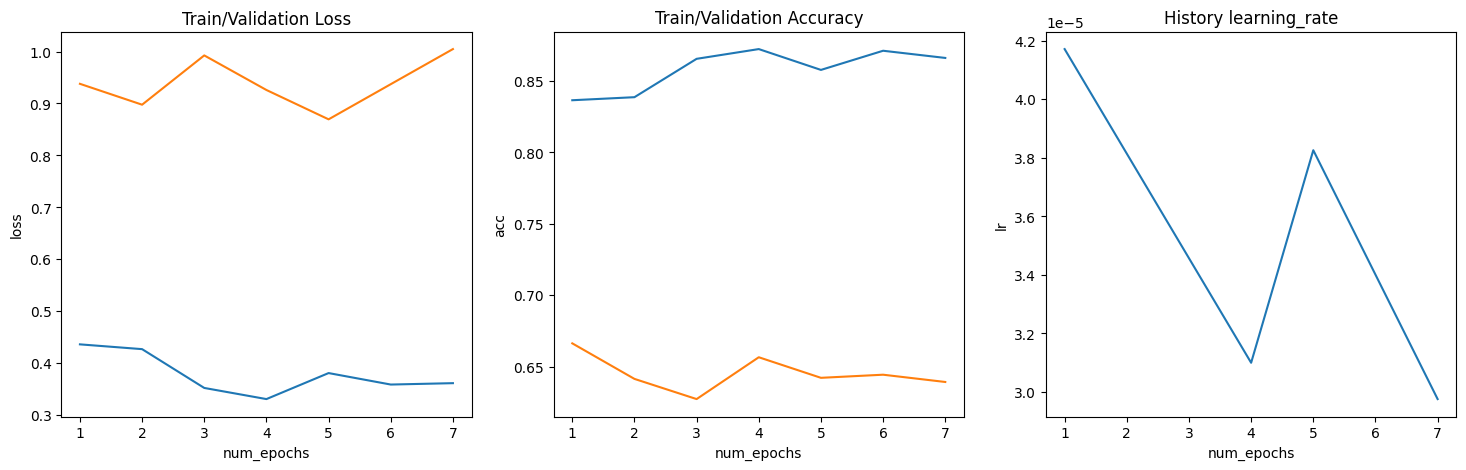

In [ ]:
train_ephs = len(hist_train_loss)
losses = (hist_train_loss, hist_valid_loss)
accuracy = (hist_train_acc, hist_valid_acc)
plot_graph(train_ephs, losses, accuracy, hist_lr)

На текущем этапе в сложных условиях тренировки и с аугментацией случайной и на train и на val проверка на тесте около 72%.
То есть лучше чем на валидации. Для условий соревнования можно оставить проверку на F1, но валидации убрать аугментацию

## Next train

### Load saved model

In [ ]:
load_dir = '/content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/NLP_course/DZ/Text_classification/Berta/'

In [ ]:
k = 1 # 1 - will loaded best_acc_model, 1 - will loaded best_loss_model
if k == 0:
  bert_classifier.load_state_dict(torch.load(load_dir + 'best_loss_aug_model.pt'))
  text_add = ' - best_loss_model'
  model_saved = True

elif k == 1:
  bert_classifier.load_state_dict(torch.load(load_dir + 'best_acc_aug_model.pt'))
  text_add = ' - best_acc_model'
  model_saved = True
print('load' + text_add)

load - best_acc_model


In [ ]:
N_EPOCHS = 7
LR_RATE = 3e-5
optimizer, lr_scheduler = update_optimizer(bert_classifier.parameters(), training_loader, LR_RATE, N_EPOCHS)

In [ ]:
JDUN_TRAIN = 2
JDUN_END = 4
EPS = 0.85
model_loss_saved = True
model_acc_saved = True


try:
  if best_valid_loss and best_valid_acc:
    pass
except:
    best_valid_loss = 0.869 #float('inf')
    best_valid_acc = 0.6663

hist_train_loss, hist_valid_loss, hist_train_acc, hist_valid_acc = [], [], [], []
hist_lr = []

save_dir = '/content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/NLP_course/DZ/Text_classification/Berta/'
path_bestacc_model = save_dir + 'best_acc_aug_model.pt'
path_bestloss_model = save_dir + 'best_loss_aug_model.pt'


wait_train = 0
wait2end = 0

for epoch in range(N_EPOCHS):
    start_time = time.time()

    # take again rand half_part from train_data, valid_data
    # training
    training_loader = get_randpart(data = train_data, params = train_params,
                                   aug = 5,
                                   part = 0.5
                                   )
    valid_loader =  get_randpart(data = valid_data, params = valid_params,
                                 aug =0,
                                 part = 1.
                                 )

    train_loss, train_acc, ep_lr = train(bert_classifier, training_loader, optimizer,
                                         lr_scheduler, criterion, f1_accuracy)
    # write history train
    hist_train_loss.append(train_loss)
    hist_train_acc.append(train_acc)

    # evaluaining
    valid_loss, valid_acc = evaluate(bert_classifier, valid_loader, criterion,
                                     f1_accuracy)
    # write history validate
    hist_valid_loss.append(valid_loss)
    hist_valid_acc.append(valid_acc)
    hist_lr.append(ep_lr)

    # timing
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    # compare results  for saving model
    text_add = ''
    # compare by loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(bert_classifier.state_dict(), path_bestloss_model)

        model_loss_saved = True
        text_add = ' - save best_loss_model'
        wait2end = 0
        wait_train = 0
        k = 0
    # compare by acc
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(bert_classifier.state_dict(), path_bestacc_model)

        model_acc_saved = True
        text_add += ' - save best_acc_model'
        wait2end = 0
        wait_train = 0
        k = 1
    else:
        wait_train+=1

    # checpoint for loading previous best model by loss or acc
    if wait_train > JDUN_TRAIN:
       if model_loss_saved and k == 0:
         bert_classifier.load_state_dict(torch.load(path_bestloss_model))
         text_add = ' - load best_loss_model'
         k = 1
       elif model_acc_saved and k == 1:
         bert_classifier.load_state_dict(torch.load(path_bestacc_model))
         text_add = ' - load best_acc_model'
         k = 0
       # update optimizer and lr_scheduler
       LR_RATE *= EPS
       optimizer, lr_scheduler = update_optimizer(bert_classifier.parameters(),
                                                  training_loader,
                                                  LR_RATE,
                                                  N_EPOCHS - epoch +1
                                                  )
       # update waitings
       wait_train = 0
       wait2end+=1

    # print loggs
    print(f'Epoch: {epoch+1:02} | with lr: {ep_lr:.9f} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain_Loss: {train_loss:.3f} | Train_Acc: {train_acc*100:.2f}%  Val_Loss: {valid_loss:.3f} | Val_Acc: {valid_acc*100:.2f}%' + text_add)

    # finish training with loading best to predict
    if wait2end > JDUN_END:
      if k == 0:
        bert_classifier.load_state_dict(torch.load(path_bestloss_model))
        text_add = ' - load best_loss_model'

      elif k == 1:
        bert_classifier.load_state_dict(torch.load(path_bestacc_model))
        text_add = ' - load best_acc_model'

      print('Stop train, do not best fitness'+ text_add)
      break

515it [01:05,  7.90it/s]


Epoch: 01 | with lr: 0.000027861 | Epoch Time: 13m 15s
	Train_Loss: 0.384 | Train_Acc: 85.74%  Val_Loss: 0.888 | Val_Acc: 67.29% - save best_acc_model


515it [01:05,  7.89it/s]


Epoch: 02 | with lr: 0.000025718 | Epoch Time: 13m 17s
	Train_Loss: 0.326 | Train_Acc: 87.33%  Val_Loss: 0.856 | Val_Acc: 68.63% - save best_loss_model - save best_acc_model


515it [01:04,  7.94it/s]


Epoch: 03 | with lr: 0.000023576 | Epoch Time: 13m 18s
	Train_Loss: 0.304 | Train_Acc: 88.24%  Val_Loss: 0.825 | Val_Acc: 68.84% - save best_loss_model - save best_acc_model


515it [01:05,  7.90it/s]


Epoch: 04 | with lr: 0.000021433 | Epoch Time: 13m 20s
	Train_Loss: 0.290 | Train_Acc: 88.83%  Val_Loss: 0.901 | Val_Acc: 69.41% - save best_acc_model


515it [01:05,  7.90it/s]


Epoch: 05 | with lr: 0.000019290 | Epoch Time: 13m 18s
	Train_Loss: 0.280 | Train_Acc: 89.68%  Val_Loss: 0.911 | Val_Acc: 69.06%


515it [01:04,  7.94it/s]


Epoch: 06 | with lr: 0.000017147 | Epoch Time: 13m 17s
	Train_Loss: 0.234 | Train_Acc: 91.46%  Val_Loss: 0.991 | Val_Acc: 68.45%


515it [01:04,  7.96it/s]


Epoch: 07 | with lr: 0.000015004 | Epoch Time: 13m 14s
	Train_Loss: 0.207 | Train_Acc: 92.47%  Val_Loss: 0.994 | Val_Acc: 68.85% - load best_acc_model


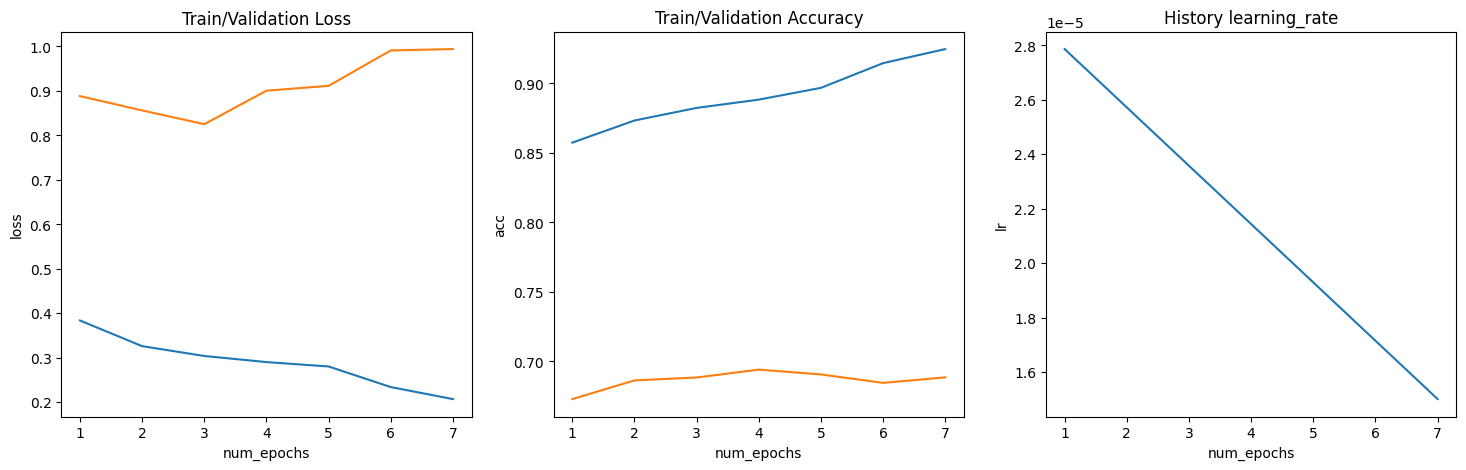

In [ ]:
train_ephs = len(hist_train_loss)
losses = (hist_train_loss, hist_valid_loss)
accuracy = (hist_train_acc, hist_valid_acc)
plot_graph(train_ephs, losses, accuracy, hist_lr)

## Next with accuracy

In [ ]:
def accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    preds = torch.argmax(preds, dim=1)

    correct = (preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
N_EPOCHS = 12
LR_RATE = 2e-5
optimizer, lr_scheduler = update_optimizer(bert_classifier, training_loader, LR_RATE, N_EPOCHS)

In [ ]:
JDUN_TRAIN = 2
JDUN_END = 4
EPS = 0.85
model_loss_saved = True
model_acc_saved = True


try:
  if best_valid_loss and best_valid_acc:
    pass
except:
    best_valid_loss = 0.699 #float('inf')
    best_valid_acc = 0.709

hist_train_loss, hist_valid_loss, hist_train_acc, hist_valid_acc = [], [], [], []
hist_lr = []

save_dir = '/content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/NLP_course/DZ/Text_classification/Berta/'
path_bestacc_model = save_dir + 'best_acc_aug_model.pt'
path_bestloss_model = save_dir + 'best_loss_aug_model.pt'


wait_train = 0
wait2end = 0

for epoch in range(N_EPOCHS):
    start_time = time.time()

    # take again rand half_part from train_data, valid_data
    # training
    training_loader = get_randpart(data = train_data, params = train_params,
                                   aug = 7,
                                   part = 0.7
                                   )
    valid_loader =  get_randpart(data = valid_data, params = valid_params,
                                 aug = 0,
                                 part = 1.
                                 )

    train_loss, train_acc, ep_lr = train(bert_classifier, training_loader, optimizer,
                                         lr_scheduler, criterion, accuracy)
    # write history train
    hist_train_loss.append(train_loss)
    hist_train_acc.append(train_acc)

    # evaluaining
    valid_loss, valid_acc = evaluate(bert_classifier, valid_loader, criterion,
                                     accuracy)
    # write history validate
    hist_valid_loss.append(valid_loss)
    hist_valid_acc.append(valid_acc)
    hist_lr.append(ep_lr)

    # timing
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    # compare results  for saving model
    text_add = ''
    # compare by loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(bert_classifier.state_dict(), path_bestloss_model)

        model_loss_saved = True
        text_add = ' - save best_loss_model'
        wait2end = 0
        wait_train = 0
        k = 0
    # compare by acc
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(bert_classifier.state_dict(), path_bestacc_model)

        model_acc_saved = True
        text_add += ' - save best_acc_model'
        wait2end = 0
        wait_train = 0
        k = 1
    else:
        wait_train+=1

    # checpoint for loading previous best model by loss or acc
    if wait_train > JDUN_TRAIN:
       if model_loss_saved and k == 0:
         bert_classifier.load_state_dict(torch.load(path_bestloss_model))
         text_add = ' - load best_loss_model'
         k = 1
       elif model_acc_saved and k == 1:
         bert_classifier.load_state_dict(torch.load(path_bestacc_model))
         text_add = ' - load best_acc_model'
         k = 0
       # update optimizer and lr_scheduler
       LR_RATE *= EPS
       optimizer, lr_scheduler = update_optimizer(bert_classifier.parameters(),
                                                  training_loader,
                                                  LR_RATE,
                                                  N_EPOCHS - epoch +1
                                                  )
       # update waitings
       wait_train = 0
       wait2end+=1

    # print loggs
    print(f'Epoch: {epoch+1:02} | with lr: {ep_lr:.9f} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain_Loss: {train_loss:.3f} | Train_Acc: {train_acc*100:.2f}%  Val_Loss: {valid_loss:.3f} | Val_Acc: {valid_acc*100:.2f}%' + text_add)

    # finish training with loading best to predict
    if wait2end > JDUN_END:
      if k == 0:
        bert_classifier.load_state_dict(torch.load(path_bestloss_model))
        text_add = ' - load best_loss_model'

      elif k == 1:
        bert_classifier.load_state_dict(torch.load(path_bestacc_model))
        text_add = ' - load best_acc_model'

      print('Stop train, do not best fitness'+ text_add)
      break

515it [01:05,  7.83it/s]


Epoch: 01 | with lr: 0.000019502 | Epoch Time: 8m 43s
	Train_Loss: 0.383 | Train_Acc: 86.13%  Val_Loss: 0.739 | Val_Acc: 74.06% - save best_acc_model


515it [01:04,  7.99it/s]


Epoch: 02 | with lr: 0.000019002 | Epoch Time: 8m 50s
	Train_Loss: 0.410 | Train_Acc: 84.95%  Val_Loss: 0.732 | Val_Acc: 73.94%


515it [01:05,  7.91it/s]


Epoch: 03 | with lr: 0.000018502 | Epoch Time: 8m 43s
	Train_Loss: 0.372 | Train_Acc: 86.32%  Val_Loss: 0.742 | Val_Acc: 74.08% - save best_acc_model


515it [01:05,  7.89it/s]


Epoch: 04 | with lr: 0.000018002 | Epoch Time: 8m 47s
	Train_Loss: 0.380 | Train_Acc: 86.13%  Val_Loss: 0.797 | Val_Acc: 74.15% - save best_acc_model


515it [01:05,  7.89it/s]


Epoch: 05 | with lr: 0.000017502 | Epoch Time: 8m 53s
	Train_Loss: 0.365 | Train_Acc: 86.69%  Val_Loss: 0.799 | Val_Acc: 73.33%


515it [01:05,  7.86it/s]


Epoch: 06 | with lr: 0.000017002 | Epoch Time: 8m 52s
	Train_Loss: 0.356 | Train_Acc: 86.81%  Val_Loss: 0.784 | Val_Acc: 74.83% - save best_acc_model


515it [01:05,  7.88it/s]


Epoch: 07 | with lr: 0.000016502 | Epoch Time: 8m 53s
	Train_Loss: 0.347 | Train_Acc: 87.15%  Val_Loss: 0.797 | Val_Acc: 74.39%


515it [01:05,  7.92it/s]


Epoch: 08 | with lr: 0.000016002 | Epoch Time: 8m 52s
	Train_Loss: 0.322 | Train_Acc: 88.18%  Val_Loss: 0.813 | Val_Acc: 74.05%


515it [01:05,  7.86it/s]


Epoch: 09 | with lr: 0.000015502 | Epoch Time: 8m 51s
	Train_Loss: 0.326 | Train_Acc: 87.86%  Val_Loss: 0.842 | Val_Acc: 74.33% - load best_acc_model


515it [01:05,  7.92it/s]


Epoch: 10 | with lr: 0.000015306 | Epoch Time: 8m 55s
	Train_Loss: 0.356 | Train_Acc: 86.85%  Val_Loss: 0.812 | Val_Acc: 73.28%


515it [01:04,  7.94it/s]


Epoch: 11 | with lr: 0.000013606 | Epoch Time: 8m 50s
	Train_Loss: 0.293 | Train_Acc: 89.41%  Val_Loss: 0.892 | Val_Acc: 72.99%


515it [01:05,  7.91it/s]


Epoch: 12 | with lr: 0.000011906 | Epoch Time: 8m 52s
	Train_Loss: 0.321 | Train_Acc: 88.39%  Val_Loss: 0.861 | Val_Acc: 73.26% - load best_loss_model


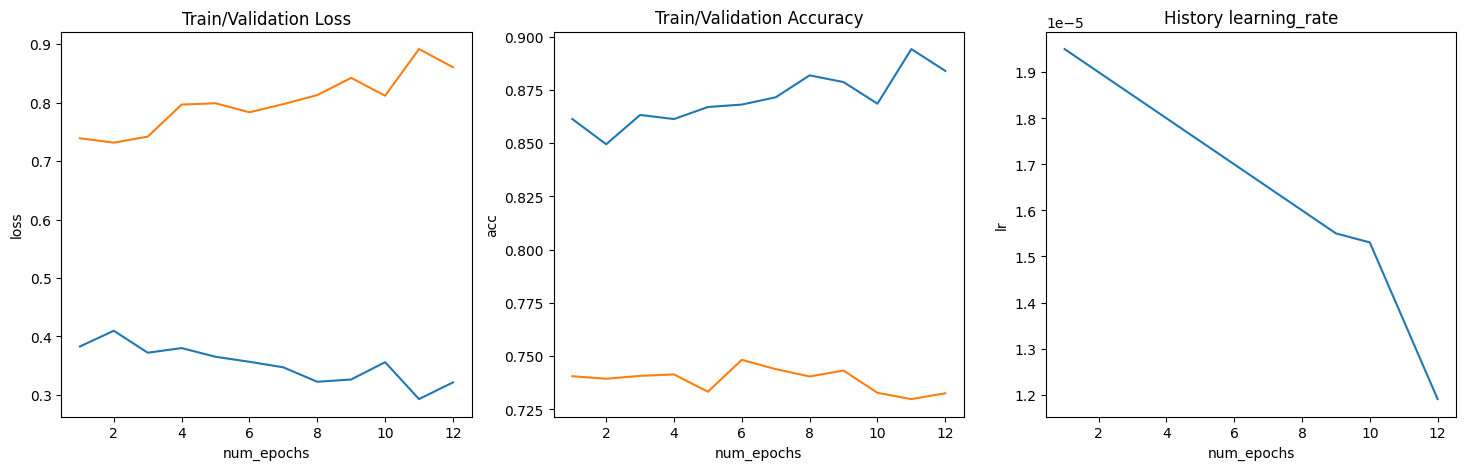

In [ ]:
train_ephs = len(hist_train_loss)
losses = (hist_train_loss, hist_valid_loss)
accuracy = (hist_train_acc, hist_valid_acc)
plot_graph(train_ephs, losses, accuracy, hist_lr)

## Train with layer-Wise Learning Rate in PyTorch
https://colab.research.google.com/github/kozodoi/website/blob/master/_notebooks/2022-03-29-discriminative-lr.ipynb#scrollTo=whn9QMjvUrwW

In [ ]:
def wise_learning_rate(model, lr, lr_mult,  show = False):

    # save layer names
    layer_names = []
    for name, param in model.named_parameters():
        layer_names.append(name)

    # reverse layers.
    layer_names.reverse()

    # placeholder
    parameters     = []
    prev_group_name = layer_names[0].split('.')[0]

    # store params & learning rates
    for idx, name in enumerate(layer_names):

        # parameter group name
        cur_group_name = name.split('.')[0]

        # update learning rate
        if cur_group_name != prev_group_name:
            lr *= lr_mult
        prev_group_name = cur_group_name

        # display info
        if show:
          print(f'{idx}: lr = {lr:.6f}, {name}')

        # append layer parameters
        parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],
                        'lr':     lr}]

    return parameters

In [ ]:
# learning rate
LR_RATE = 3e-3
parameters = wise_learning_rate(bert_classifier, LR_RATE, lr_mult = 0.09,  show = True)

0: lr = 0.003000, classifier.bias
1: lr = 0.003000, classifier.weight
2: lr = 0.000270, pre_classifier_2.0.bias
3: lr = 0.000270, pre_classifier_2.0.weight
4: lr = 0.000024, pre_classifier_1.0.bias
5: lr = 0.000024, pre_classifier_1.0.weight
6: lr = 0.000002, bert.pooler.dense.bias
7: lr = 0.000002, bert.pooler.dense.weight
8: lr = 0.000002, bert.encoder.layer.11.output.LayerNorm.bias
9: lr = 0.000002, bert.encoder.layer.11.output.LayerNorm.weight
10: lr = 0.000002, bert.encoder.layer.11.output.dense.bias
11: lr = 0.000002, bert.encoder.layer.11.output.dense.weight
12: lr = 0.000002, bert.encoder.layer.11.intermediate.dense.bias
13: lr = 0.000002, bert.encoder.layer.11.intermediate.dense.weight
14: lr = 0.000002, bert.encoder.layer.11.attention.output.LayerNorm.bias
15: lr = 0.000002, bert.encoder.layer.11.attention.output.LayerNorm.weight
16: lr = 0.000002, bert.encoder.layer.11.attention.output.dense.bias
17: lr = 0.000002, bert.encoder.layer.11.attention.output.dense.weight
18: lr =

### Load saved model

In [ ]:
load_dir = '/content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/NLP_course/DZ/Text_classification/Berta/'

In [ ]:
k = 1 # 1 - will loaded best_acc_model, 1 - will loaded best_loss_model
if k == 0:
  bert_classifier.load_state_dict(torch.load(load_dir + 'best_loss_aug_model.pt'))
  text_add = ' - best_loss_model'
  model_saved = True

elif k == 1:
  bert_classifier.load_state_dict(torch.load(load_dir + 'best_acc_aug_model.pt'))
  text_add = ' - best_acc_model'
  model_saved = True
print('load' + text_add)

load - best_acc_model


In [ ]:
# take again rand half_part from train_data, valid_data
# training
training_loader = get_randpart(data = train_data, params = train_params,
                                aug = 0,
                                part = 1.
                                )
valid_loader =  get_randpart(data = valid_data, params = valid_params,
                              aug = 0,
                              part = 1.
                              )

In [ ]:
criterion = nn.CrossEntropyLoss().to(DEVICE) # учет весов классов не сильно момогает в результате
N_EPOCHS = 8
# learning rate
LR_RATE = 2e-3
parameters = wise_learning_rate(bert_classifier, LR_RATE, lr_mult = 0.09,  show = False)
optimizer, lr_scheduler = update_optimizer(parameters, training_loader, LR_RATE, N_EPOCHS)

In [ ]:
JDUN_TRAIN = 2
JDUN_END = 4
EPS = 0.85
model_loss_saved = True
model_acc_saved = True


try:
  if best_valid_loss and best_valid_acc:
    pass
except:
    best_valid_loss = 0.699 #float('inf')
    best_valid_acc = 0.7814

hist_train_loss, hist_valid_loss, hist_train_acc, hist_valid_acc = [], [], [], []
hist_lr = []

save_dir = '/content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/NLP_course/DZ/Text_classification/Berta/'
path_bestacc_model = save_dir + 'best_acc_aug_model.pt'
path_bestloss_model = save_dir + 'best_loss_aug_model.pt'


wait_train = 0
wait2end = 0

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc, ep_lr = train(bert_classifier, training_loader, optimizer,
                                         lr_scheduler, criterion, accuracy)
    # write history train
    hist_train_loss.append(train_loss)
    hist_train_acc.append(train_acc)

    # evaluaining
    valid_loss, valid_acc = evaluate(bert_classifier, valid_loader, criterion,
                                     accuracy)
    # write history validate
    hist_valid_loss.append(valid_loss)
    hist_valid_acc.append(valid_acc)
    hist_lr.append(ep_lr)

    # timing
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    # compare results  for saving model
    text_add = ''
    # compare by loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(bert_classifier.state_dict(), path_bestloss_model)

        model_loss_saved = True
        text_add = ' - save best_loss_model'
        wait2end = 0
        wait_train = 0
        k = 0
    # compare by acc
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(bert_classifier.state_dict(), path_bestacc_model)

        model_acc_saved = True
        text_add += ' - save best_acc_model'
        wait2end = 0
        wait_train = 0
        k = 1
    else:
        wait_train+=1

    # checpoint for loading previous best model by loss or acc
    if wait_train > JDUN_TRAIN:
       if model_loss_saved and k == 0:
         bert_classifier.load_state_dict(torch.load(path_bestloss_model))
         text_add = ' - load best_loss_model'
         k = 1
       elif model_acc_saved and k == 1:
         bert_classifier.load_state_dict(torch.load(path_bestacc_model))
         text_add = ' - load best_acc_model'
         k = 0
       # update optimizer and lr_scheduler
       LR_RATE *= EPS
       parameters = wise_learning_rate(bert_classifier, LR_RATE,
                                       lr_mult = 0.09,  show = False)

       optimizer, lr_scheduler = update_optimizer(parameters,
                                                  training_loader,
                                                  LR_RATE,
                                                  N_EPOCHS - epoch +1
                                                  )
       # update waitings
       wait_train = 0
       wait2end += 1

    # print loggs
    print(f'Epoch: {epoch+1:02} | with lr: {ep_lr:.9f} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain_Loss: {train_loss:.3f} | Train_Acc: {train_acc*100:.2f}%  Val_Loss: {valid_loss:.3f} | Val_Acc: {valid_acc*100:.2f}%' + text_add)

    # finish training with loading best to predict
    if wait2end > JDUN_END:
      if k == 0:
        bert_classifier.load_state_dict(torch.load(path_bestloss_model))
        text_add = ' - load best_loss_model'

      elif k == 1:
        bert_classifier.load_state_dict(torch.load(path_bestacc_model))
        text_add = ' - load best_acc_model'

      print('Stop train, do not best fitness'+ text_add)
      break

515it [01:08,  7.50it/s]


Epoch: 01 | with lr: 0.001874879 | Epoch Time: 21m 9s
	Train_Loss: 0.058 | Train_Acc: 98.33%  Val_Loss: 1.545 | Val_Acc: 77.91%


515it [01:09,  7.45it/s]


Epoch: 02 | with lr: 0.001749879 | Epoch Time: 21m 21s
	Train_Loss: 0.055 | Train_Acc: 98.48%  Val_Loss: 1.519 | Val_Acc: 77.95%


515it [01:08,  7.47it/s]


Epoch: 03 | with lr: 0.001624879 | Epoch Time: 21m 13s
	Train_Loss: 0.046 | Train_Acc: 98.61%  Val_Loss: 1.666 | Val_Acc: 77.89% - load best_acc_model


515it [01:08,  7.48it/s]


Epoch: 04 | with lr: 0.001578689 | Epoch Time: 21m 15s
	Train_Loss: 0.057 | Train_Acc: 98.40%  Val_Loss: 1.577 | Val_Acc: 78.19% - save best_acc_model


515it [01:08,  7.48it/s]


Epoch: 05 | with lr: 0.001457261 | Epoch Time: 21m 15s
	Train_Loss: 0.054 | Train_Acc: 98.45%  Val_Loss: 1.540 | Val_Acc: 77.89%


515it [01:08,  7.51it/s]


Epoch: 06 | with lr: 0.001335832 | Epoch Time: 21m 9s
	Train_Loss: 0.048 | Train_Acc: 98.64%  Val_Loss: 1.600 | Val_Acc: 77.90%


515it [01:09,  7.46it/s]


Epoch: 07 | with lr: 0.001214404 | Epoch Time: 21m 12s
	Train_Loss: 0.045 | Train_Acc: 98.69%  Val_Loss: 1.613 | Val_Acc: 78.10% - load best_acc_model


515it [01:08,  7.57it/s]

Epoch: 08 | with lr: 0.001204401 | Epoch Time: 20m 53s
	Train_Loss: 0.049 | Train_Acc: 98.67%  Val_Loss: 1.708 | Val_Acc: 77.99%


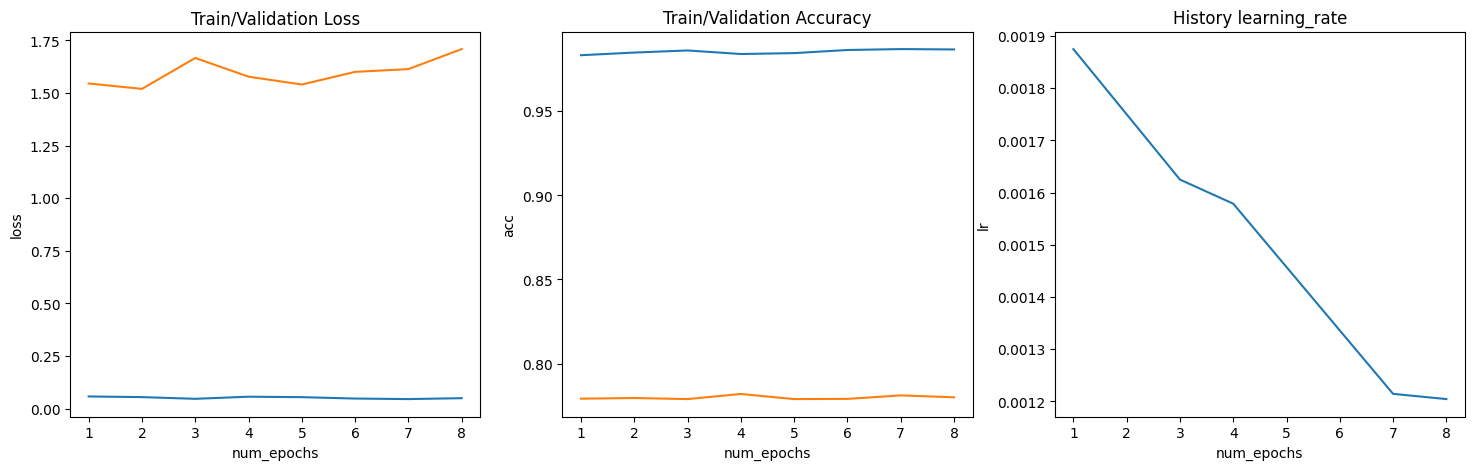

In [ ]:
train_ephs = len(hist_train_loss)
losses = (hist_train_loss, hist_valid_loss)
accuracy = (hist_train_acc, hist_valid_acc)
plot_graph(train_ephs, losses, accuracy, hist_lr)

# Plot_confusion_matrix

In [ ]:
def confusion_matrix(y_true, y_pred, labels=None, normalize=None,
                     cmap="Blues", encoded_labels=True,
                     plot=True, verbose = False):
    """
    Args:
        y_true (ndarray)
        y_pred (ndarray)
        labels (list)
        normalise (str) : {'all', None}
        cmap (maplotlib.pyplot.cmap)
        encoded_labels (bool): Need to be False if labels are not one hot encoded
        plot (bool): If False, plot will not appear for confusion matrix

    Return:
        conf_mat (tuple): TN, FP, FN, TP
    """

    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    if normalize not in ('all', None):
        raise ValueError("normalize must be one of {'all', None}")

    conf_labels = None if encoded_labels else labels
    fmt = 'g' if normalize == None else '.2%'

    conf_mat = confusion_matrix(y_true, y_pred, normalize=normalize, labels=conf_labels)

    if plot:
        plt.figure(figsize = (10,10))
        ax = sns.heatmap(conf_mat, cmap=cmap,
                         square=True, cbar=False,
                         annot=True, fmt=fmt,
                         annot_kws={'fontsize': 15,
                                    'fontweight': 'bold',
                                    'fontfamily': 'serif',
                                    }
                         )
        ax.set_title("Confusion Matrix", fontsize=18)
        ax.set_xlabel("Predicted", fontsize=11, color = "red")
        ax.set_ylabel("Actual", fontsize=11, color = "red")
        if labels != None:
            ax.set_yticklabels(labels,  fontsize=12)
            ax.set_xticklabels(labels,  fontsize=12)
    if verbose: return conf_mat

In [ ]:
pred_lbls, y_val_lbls = predict_both(bert_classifier, valid_loader)

515it [01:06,  7.80it/s]


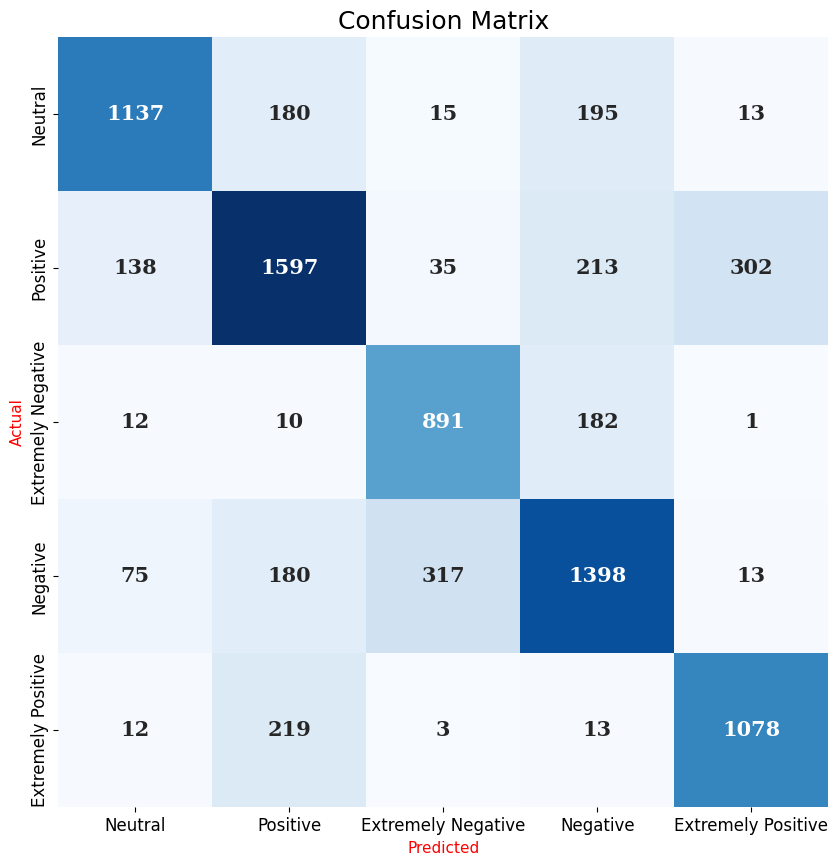

In [ ]:
confusion_matrix(y_val_lbls, pred_lbls, labels=dict_sent_to_lbl.keys()) #, normalize='all')

# Predict test

In [ ]:
sentiments = []

bert_classifier.eval()
with torch.inference_mode():
    for i, row in tqdm(test_ds.iterrows(), total=test_ds.shape[0]):

        # Cleanup and tokenize the sentence
        text = row['Text_clean']

        inputs = tokenizer.encode_plus(
                                        text,
                                        None,
                                        add_special_tokens=True,
                                        max_length=MAX_LEN,
                                        pad_to_max_length=True,
                                        return_token_type_ids=True
                                    )
        # get input_ids, attention_mask, token_type_ids
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        #token_type_ids = inputs["token_type_ids"]
        input_ids = torch.tensor([input_ids], dtype=torch.long).to(DEVICE)
        attention_mask = torch.tensor([attention_mask], dtype=torch.long).to(DEVICE)
        #token_type_ids = torch.tensor([token_type_ids], dtype=torch.long).to(DEVICE)


        # Get predictions
        logits = bert_classifier(
                                  input_ids,
                                  attention_mask=attention_mask,
                                  #token_type_ids = token_type_ids
                                 )
        pred = torch.argmax(logits, 1)
        # Convert the integer category value to its actual name and save in predictions list
        sentiments.append(dict_lbl_to_sent[pred.item()])

# Save the predictions in Pandas column
test_ds['Sentiment'] = sentiments

100%|██████████| 3798/3798 [00:55<00:00, 68.99it/s]


In [ ]:
sample_submission.Sentiment = test_ds['Sentiment'].values
sample_submission.head()

,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Negative
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Positive
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Positive
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Extremely Negative
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral


# Сабмит в Kaggle сразу

In [ ]:
file_name = 'submission.csv'
# сохраняем с колонкой Id
sample_submission.to_csv(file_name, index=False)

Старый для проб

In [ ]:
!kaggle competitions submit -c nlp-txt-classification -f submission.csv -m "from colab_tests"

100% 182k/182k [00:01<00:00, 139kB/s]
Successfully submitted to Unit 3 - Text Classification

Основной

In [ ]:
!kaggle competitions submit -c unit-3-nlp-txt-classification -f submission.csv -m "From colab - Berta"

100% 183k/183k [00:04<00:00, 44.6kB/s]
Successfully submitted to Unit 3 - Классификация текстов